In [ ]:

import pandas as pd

df = pd.read_csv('/content/cleaned_song_data_earliest_year_song_artist_key.csv')
df.columns


Index(['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned', 'lyrics',
       'word_count', 'char_count', 'unique_word_count', 'unique_words',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'pattern', 'se

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

import ast
import time
import sys

input_file_path = 'cleaned_song_data_earliest_year_song_artist_key.csv'
ranking_threshold = 20
target_column_name = 'is_top_20'

def preprocess_lyrics_string(lyric_str):
    if pd.isna(lyric_str) or not isinstance(lyric_str, str):
        return ""
    if lyric_str.startswith('[') and lyric_str.endswith(']'):
        try:
            word_list = ast.literal_eval(lyric_str)
            if isinstance(word_list, list):
                return " ".join(str(word) for word in word_list)
            return lyric_str
        except (ValueError, SyntaxError):
            return lyric_str
    return lyric_str

print(f"Reading data from: {input_file_path}")
try:
    df = pd.read_csv(input_file_path)
    print(f"Successfully read data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found.", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    sys.exit(f"Error reading file: {e}")

print("\nPreprocessing data...")

lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    sys.exit(f"ERROR: Lyrics column ('lyrics_cleaned' or 'lyrics') not found.")
print(f"Using '{lyrics_col_name}' for lyrics text.")

if 'ranking' not in df.columns:
    sys.exit("ERROR: 'ranking' column not found for target creation.")

print(f"Preprocessing content of lyrics column: '{lyrics_col_name}'...")
df[lyrics_col_name] = df[lyrics_col_name].apply(preprocess_lyrics_string)
df[lyrics_col_name].replace('', np.nan, inplace=True)

df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df.dropna(subset=['ranking', lyrics_col_name], inplace=True)
df[target_column_name] = (df['ranking'] <= ranking_threshold).astype(int)
print(f"Target variable '{target_column_name}' created.")
print(f"Value counts for target:\n{df[target_column_name].value_counts(normalize=True)}")


y = df[target_column_name]

columns_to_drop_from_X = [
    'song', 'artist', 'year', 'ranking', 'MYCS',
    'year_list', 'ranking_list', target_column_name
]
if 'lyrics' not in columns_to_drop_from_X: columns_to_drop_from_X.append('lyrics')
if 'lyrics_cleaned' not in columns_to_drop_from_X: columns_to_drop_from_X.append('lyrics_cleaned')

X = df.drop(columns=[col for col in columns_to_drop_from_X if col in df.columns and col != lyrics_col_name], errors='ignore')

print(f"Features for modeling (X shape): {X.shape}")


categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
if lyrics_col_name in categorical_features:
    categorical_features.remove(lyrics_col_name)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
if lyrics_col_name in numerical_features:
    numerical_features.remove(lyrics_col_name)


print(f"Numerical features for preprocessing: {numerical_features}")
print(f"Categorical features for preprocessing: {categorical_features}")

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2)
)

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, lyrics_col_name),
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)


models = {
    "LightGBM": lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=42, n_jobs=-1, metric='auc'),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),

}

print("\n--- Model Evaluation with 5-Fold Stratified Cross-Validation ---")
strat_k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_positive': make_scorer(f1_score, pos_label=1, zero_division=0),
    'recall_positive': make_scorer(recall_score, pos_label=1, zero_division=0),
    'precision_positive': make_scorer(precision_score, pos_label=1, zero_division=0)
}

results_summary = {}

for model_name, model_instance in models.items():
    start_time = time.time()
    print(f"\nEvaluating {model_name}...")

    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_instance)
    ])

    try:
        cv_results = cross_validate(full_pipeline, X, y, cv=strat_k_folds, scoring=scoring_metrics, n_jobs=-1)
        end_time = time.time()

        results_summary[model_name] = {
            "Mean ROC AUC": np.mean(cv_results['test_roc_auc']),
            "Std ROC AUC": np.std(cv_results['test_roc_auc']),
            "Mean F1 Macro": np.mean(cv_results['test_f1_macro']),
            "Std F1 Macro": np.std(cv_results['test_f1_macro']),
            "Mean Recall Positive": np.mean(cv_results['test_recall_positive']),
            "Std Recall Positive": np.std(cv_results['test_recall_positive']),
            "Mean Precision Positive": np.mean(cv_results['test_precision_positive']),
            "Std Precision Positive": np.std(cv_results['test_precision_positive']),
            "Mean F1 Positive": np.mean(cv_results['test_f1_positive']),
            "Std F1 Positive": np.std(cv_results['test_f1_positive']),
            "Mean Accuracy": np.mean(cv_results['test_accuracy']),
            "Time (s)": end_time - start_time
        }

        print(f"{model_name} - Mean ROC AUC: {results_summary[model_name]['Mean ROC AUC']:.4f} (+/- {results_summary[model_name]['Std ROC AUC']:.4f})")
        print(f"{model_name} - Mean F1 Macro: {results_summary[model_name]['Mean F1 Macro']:.4f} (+/- {results_summary[model_name]['Std F1 Macro']:.4f})")
        print(f"{model_name} - Mean Recall (Top 20): {results_summary[model_name]['Mean Recall Positive']:.4f} (+/- {results_summary[model_name]['Std Recall Positive']:.4f})")
        print(f"{model_name} - Evaluation Time: {results_summary[model_name]['Time (s)']:.2f} seconds")

    except Exception as e:
        end_time = time.time()
        print(f"ERROR evaluating {model_name}: {e}")
        results_summary[model_name] = {"Error": str(e), "Time (s)": end_time - start_time}


print("\n\n--- Summary of Cross-Validation Results for Top 20 Classification ---")
results_df = pd.DataFrame(results_summary).T
results_df = results_df.sort_values(by="Mean Recall Positive", ascending=False)
print(results_df)

print("\n--- Script Finished ---")


Reading data from: cleaned_song_data_earliest_year_song_artist_key.csv
Successfully read data. Shape: (5618, 68)

Preprocessing data...
Using 'lyrics_cleaned' for lyrics text.
Preprocessing content of lyrics column: 'lyrics_cleaned'...
Target variable 'is_top_20' created.
Value counts for target:
is_top_20
0    0.79773
1    0.20227
Name: proportion, dtype: float64
Features for modeling (X shape): (5374, 62)
Numerical features for preprocessing: ['word_count', 'char_count', 'unique_word_count', 'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio', 'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity', 'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count', 'distinct_stopword_count', 'stopword_repetition_ratio', 'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person', 'second_person', 'third_person', 'male_pronouns', 'female_pronouns', 'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio', 'second_person_ratio', 'third_person_ratio', 'm

<ipython-input-6-5d0e59860f1f>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[lyrics_col_name].replace('', np.nan, inplace=True) # Treat genuinely empty strings as NaN


LightGBM - Mean ROC AUC: nan (+/- nan)
LightGBM - Mean F1 Macro: 0.5331 (+/- 0.0102)
LightGBM - Mean Recall (Top 20): 0.2327 (+/- 0.0179)
LightGBM - Evaluation Time: 112.25 seconds

Evaluating Logistic Regression...
Logistic Regression - Mean ROC AUC: nan (+/- nan)
Logistic Regression - Mean F1 Macro: 0.5396 (+/- 0.0133)
Logistic Regression - Mean Recall (Top 20): 0.3164 (+/- 0.0297)
Logistic Regression - Evaluation Time: 19.49 seconds

Evaluating Random Forest...
Random Forest - Mean ROC AUC: nan (+/- nan)
Random Forest - Mean F1 Macro: 0.4493 (+/- 0.0024)
Random Forest - Mean Recall (Top 20): 0.0064 (+/- 0.0023)
Random Forest - Evaluation Time: 52.48 seconds

Evaluating AdaBoost...
AdaBoost - Mean ROC AUC: nan (+/- nan)
AdaBoost - Mean F1 Macro: 0.4437 (+/- 0.0001)
AdaBoost - Mean Recall (Top 20): 0.0000 (+/- 0.0000)
AdaBoost - Evaluation Time: 277.60 seconds


--- Summary of Cross-Validation Results for Top 20 Classification ---
                     Mean ROC AUC  Std ROC AUC  Mean F

Reading expanded data from: cleaned_song_data_earliest_year_song_artist_key.csv
Successfully read data. Shape: (5618, 68)

Preprocessing...
Preprocessing content of lyrics column: 'lyrics_cleaned'...
Finished preprocessing lyrics column content.
Target variable counts:
is_top_20
0    4287
1    1087
Name: count, dtype: int64


<ipython-input-8-e5c60b2b77ea>:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[lyrics_col_name].replace('', np.nan, inplace=True)



TF-IDF Vectorization...

Combining features...

Applying SMOTE...
SMOTE Class distribution:
is_top_20
0    3429
1    3429
Name: count, dtype: int64

Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3429, number of negative: 3429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105443
[LightGBM] [Info] Number of data points in the train set: 6858, number of used features: 1087
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training completed in 12.32 seconds.

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.80      0.98      0.88       858
  Rank <= 20       0.19      0.02      0.03       217

    accuracy                           0.79      1075
   macro avg       0.49      0.50      0.46      1075
weighted avg       0.68      0.79      0.71      1075


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


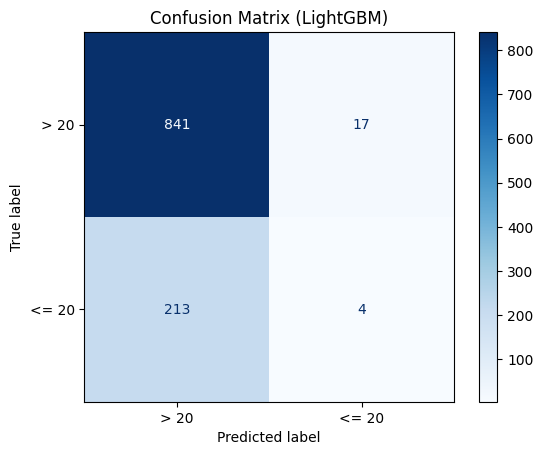


ROC AUC Score: 0.6096
Precision-Recall AUC Score: 0.2489


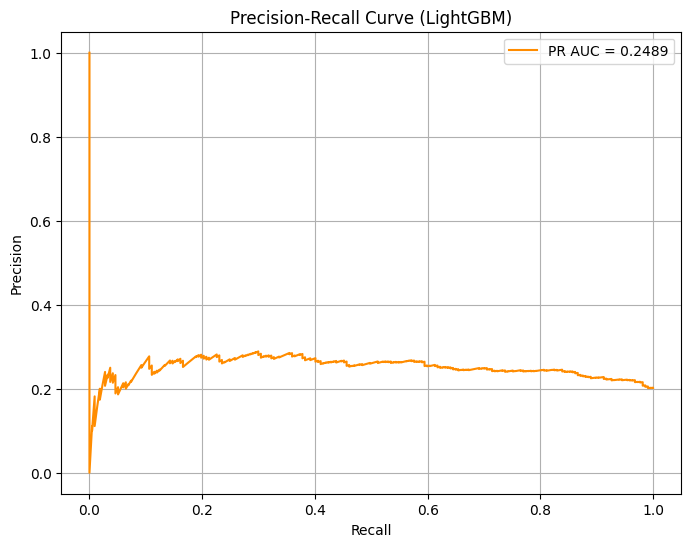


--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time
from imblearn.over_sampling import SMOTE
import ast

input_file_path = 'cleaned_song_data_earliest_year_song_artist_key.csv'
ranking_threshold = 20

def preprocess_lyrics_string(lyric_str):
    """
    Converts a string representation of a list of words into a single space-separated string.
    Example: "['hello', 'world']" -> "hello world"
    """
    if pd.isna(lyric_str) or not isinstance(lyric_str, str):
        return ""

    if lyric_str.startswith('[') and lyric_str.endswith(']'):
        try:
            word_list = ast.literal_eval(lyric_str)
            if isinstance(word_list, list):

                return " ".join(str(word) for word in word_list)
            else:

                return lyric_str
        except (ValueError, SyntaxError):

            return lyric_str
    return lyric_str

print(f"Reading expanded data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        sys.exit(f"Unsupported file format: {input_file_path}")
    print(f"Successfully read data. Shape: {df.shape}")
except Exception as e:
    sys.exit(f"Error reading file: {e}")

print("\nPreprocessing...")
lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    sys.exit(f"ERROR: Lyrics column ('lyrics_cleaned' or 'lyrics') not found.")
if 'ranking' not in df.columns:
    sys.exit("ERROR: 'ranking' column not found.")

print(f"Preprocessing content of lyrics column: '{lyrics_col_name}'...")
df[lyrics_col_name] = df[lyrics_col_name].apply(preprocess_lyrics_string)
print("Finished preprocessing lyrics column content.")

df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df[lyrics_col_name].replace('', np.nan, inplace=True)
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()

df_processed['is_top_20'] = (df_processed['ranking'] <= ranking_threshold).astype(int)

print(f"Target variable counts:\n{df_processed['is_top_20'].value_counts()}")

columns_to_drop = ['song', 'artist', 'year', 'ranking', 'MYCS', 'year_list', 'ranking_list']
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    if other_lyrics != lyrics_col_name:
        columns_to_drop.append(other_lyrics)

columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]

y = df_processed['is_top_20']
lyrics_data = df_processed[lyrics_col_name]
X = df_processed.drop(columns=[*columns_to_drop_existing, 'is_top_20', lyrics_col_name], errors='ignore')

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())


X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTF-IDF Vectorization...")
if not isinstance(lyrics_train.iloc[0], str) if not lyrics_train.empty else False:
     print("Warning: lyrics_train does not appear to be a Series of strings. Check preprocessing.", file=sys.stderr)
if not isinstance(lyrics_test.iloc[0], str) if not lyrics_test.empty else False:
     print("Warning: lyrics_test does not appear to be a Series of strings. Check preprocessing.", file=sys.stderr)

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)

tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=vectorizer.get_feature_names_out())

print("\nCombining features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"SMOTE Class distribution:\n{pd.Series(y_train_resampled).value_counts()}")

print("\nTraining LightGBM...")
basic_lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
basic_lgbm_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

print("\nEvaluating model...")
y_pred = basic_lgbm_model.predict(X_test_scaled)
y_proba = basic_lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))

print("\nConfusion Matrix:")
try:
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (LightGBM)')
    plt.show()
except Exception as e:
    print(f"Could not display Confusion Matrix: {e}")


roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

try:
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='darkorange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (LightGBM)')
    plt.grid(True)
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not display Precision-Recall Curve: {e}")

print("\n--- Script Finished ---")


Reading data from: cleaned_song_data_earliest_year_song_artist_key.csv
Successfully read data. Shape: (5618, 68)

Starting preprocessing...
Preprocessing content of lyrics column: 'lyrics_cleaned'...
Finished preprocessing lyrics column content.
Shape after dropping NaNs in ranking/lyrics: (5374, 68)

Target variable 'is_top_20' created (1 if ranking <= 20, 0 otherwise).
Value counts for target:
is_top_20
0    4287
1    1087
Name: count, dtype: int64


<ipython-input-10-1c026d12755b>:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[lyrics_col_name].replace('', np.nan, inplace=True)


Number of non-lyric features after preprocessing: 7438

Performing Train-Test Split...
Train size: 4299, Test size: 1075
Train target distribution:
is_top_20
0    0.797627
1    0.202373
Name: proportion, dtype: float64
Test target distribution:
is_top_20
0    0.79814
1    0.20186
Name: proportion, dtype: float64

Applying TF-IDF to lyrics (removing stopwords)...
Number of TF-IDF features: 1000

Combining numerical features with TF-IDF features...
Total number of features after combining: 8438

Scaling combined feature set...

SMOTE is NOT being applied in this version.

Training LightGBM Classifier model with class_weight='balanced' (NO SMOTE)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 870, number of negative: 3429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68349
[LightGBM] [Info] Number of data points in the train set: 4299, number of used features: 1055
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Model training finished in 7.70 seconds.

Evaluating model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Top 20 Classification Performance Metrics (No SMOTE) ---

Classification Report:
              precision    recall  f1-score   support

   Rank > 20       0.81      0.84      0.82       858
  Rank <= 20       0.25      0.21      0.23       217

    accuracy                           0.71      1075
   macro avg       0.53      0.52      0.53      1075
weighted avg       0.69      0.71      0.70      1075


Confusion Matrix:


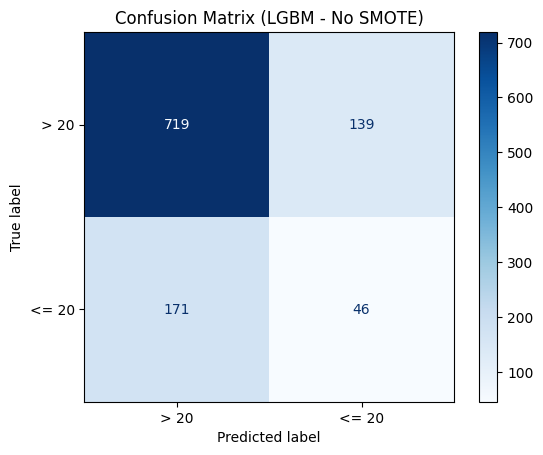


ROC AUC Score: 0.5938
Precision-Recall AUC Score: 0.2523


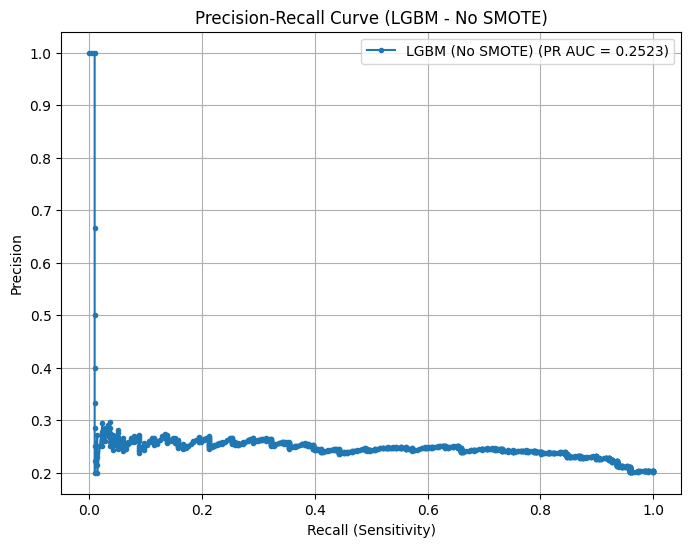


--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import sys
import time
import ast
input_file_path = 'cleaned_song_data_earliest_year_song_artist_key.csv'
ranking_threshold = 20

def preprocess_lyrics_string(lyric_str):
    """
    Converts a string representation of a list of words into a single space-separated string.
    Example: "['hello', 'world']" -> "hello world"
    """
    if pd.isna(lyric_str) or not isinstance(lyric_str, str):
        return ""

    if lyric_str.startswith('[') and lyric_str.endswith(']'):
        try:
            word_list = ast.literal_eval(lyric_str)
            if isinstance(word_list, list):
                return " ".join(str(word) for word in word_list)
            else:
                return lyric_str
        except (ValueError, SyntaxError):
            return lyric_str
    return lyric_str

print(f"Reading data from: {input_file_path}")
try:
    if input_file_path.endswith('.csv'):
        df = pd.read_csv(input_file_path)
    elif input_file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(input_file_path)
    else:
        print(f"Error: Unsupported file format for {input_file_path}. Please use CSV or Excel.", file=sys.stderr)
        df = None

    if df is None:
        sys.exit("Exiting due to file reading error.")

    print(f"Successfully read data. Shape: {df.shape}")

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found.", file=sys.stderr)
    print("Please make sure the file exists and the path is correct.", file=sys.stderr)
    sys.exit("Exiting due to file not found.")
except Exception as e:
    print(f"\nAn error occurred during file reading: {e}", file=sys.stderr)
    sys.exit("Exiting due to file reading error.")

print("\nStarting preprocessing...")

lyrics_col_name = 'lyrics_cleaned' if 'lyrics_cleaned' in df.columns else 'lyrics'
if lyrics_col_name not in df.columns:
    print(f"ERROR: Neither 'lyrics_cleaned' nor 'lyrics' found in DataFrame.", file=sys.stderr)
    sys.exit("Exiting due to missing lyrics column.")

if 'ranking' not in df.columns:
    print("Error: 'ranking' column not found.", file=sys.stderr)
    sys.exit("Exiting due to missing ranking column.")

print(f"Preprocessing content of lyrics column: '{lyrics_col_name}'...")
df[lyrics_col_name] = df[lyrics_col_name].apply(preprocess_lyrics_string)
print("Finished preprocessing lyrics column content.")

df['ranking'] = pd.to_numeric(df['ranking'], errors='coerce')
df[lyrics_col_name].replace('', np.nan, inplace=True)
df_processed = df.dropna(subset=['ranking', lyrics_col_name]).copy()
print(f"Shape after dropping NaNs in ranking/lyrics: {df_processed.shape}")

target_col = 'is_top_20'
df_processed[target_col] = (df_processed['ranking'] <= ranking_threshold).astype(int)
print(f"\nTarget variable '{target_col}' created (1 if ranking <= {ranking_threshold}, 0 otherwise).")
print(f"Value counts for target:\n{df_processed[target_col].value_counts()}")

columns_to_drop = [
    'song', 'artist', 'year', 'ranking', 'MYCS',
    'year_list', 'ranking_list'
]
if 'lyrics_cleaned' in df.columns and 'lyrics' in df.columns:
    other_lyrics = 'lyrics' if lyrics_col_name == 'lyrics_cleaned' else 'lyrics_cleaned'
    if other_lyrics != lyrics_col_name:
        columns_to_drop.append(other_lyrics)

y = df_processed[target_col]
columns_to_drop_existing = [col for col in columns_to_drop if col in df_processed.columns]
X = df_processed.drop(columns=columns_to_drop_existing + [target_col, lyrics_col_name], errors='ignore')

lyrics_data = df_processed[lyrics_col_name]
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())
numerical_feature_names = X.columns.tolist()
print(f"Number of non-lyric features after preprocessing: {len(numerical_feature_names)}")

print("\nPerforming Train-Test Split...")
X_train_num, X_test_num, lyrics_train, lyrics_test, y_train, y_test = train_test_split(
    X, lyrics_data, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train_num.shape[0]}, Test size: {X_test_num.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

print("\nApplying TF-IDF to lyrics (removing stopwords)...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_train_sparse = vectorizer.fit_transform(lyrics_train)
tfidf_test_sparse = vectorizer.transform(lyrics_test)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf_feature_names)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), columns=tfidf_feature_names)
print(f"Number of TF-IDF features: {len(tfidf_feature_names)}")

print("\nCombining numerical features with TF-IDF features...")
X_train_combined = pd.concat([X_train_num.reset_index(drop=True), tfidf_train_df.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)
combined_feature_names = X_train_combined.columns.tolist()
print(f"Total number of features after combining: {len(combined_feature_names)}")

print("\nScaling combined feature set...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("\nSMOTE is NOT being applied in this version.")

print("\nTraining LightGBM Classifier model with class_weight='balanced' (NO SMOTE)...")
model_lgbm_clf_top20 = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
model_lgbm_clf_top20.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Model training finished in {end_time - start_time:.2f} seconds.")

print("\nEvaluating model...")
y_pred_clf = model_lgbm_clf_top20.predict(X_test_scaled)
y_pred_proba_clf = model_lgbm_clf_top20.predict_proba(X_test_scaled)[:, 1]

print("\n--- Top 20 Classification Performance Metrics (No SMOTE) ---")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_clf, target_names=[f'Rank > {ranking_threshold}', f'Rank <= {ranking_threshold}']))

print("\nConfusion Matrix:")
try:
    cm = confusion_matrix(y_test, y_pred_clf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'> {ranking_threshold}', f'<= {ranking_threshold}'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (LGBM - No SMOTE)')
    plt.show()
except Exception as e:
    print(f"Could not display Confusion Matrix: {e}")

roc_auc = roc_auc_score(y_test, y_pred_proba_clf)
print(f"\nROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_clf)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

try:
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'LGBM (No SMOTE) (PR AUC = {pr_auc:.4f})')
    plt.title('Precision-Recall Curve (LGBM - No SMOTE)')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not display Precision-Recall Curve: {e}")

print("\n--- Script Finished ---")
